**Введенский Вячеслав Владимирович  
MADE-ML-32**

Оценочные расчёты делаются на 400_000 или 1_000_000 итераций.

| Окружение/Стратегия | Метод | Выигрыш | 
|---------|-----------:|---------:|
| Случайная | ---- | -0.38 |
| Простая | ---- | -0.18 |
| Базовое окружение | MC | -0.055 |
| Базовое окружение | QL | -0.055 |
| Базовое, с учётом тузов | MC | -0.043 |
| Базовое, с учётом тузов | QL | -0.043 |
| С удвоением | MC | -0.032 |
| С удвоением | QL | -0.031 |
| С удвоением + подсчёт карт | MC | -0.009 |
| С удвоением + подсчёт карт | QL | -0.009 |
| С удвоением + подсчёт карт + Split | MC | -0.008 |

MC = Monte Carlo control with exploring starts  
QL = QLearning

**С учётом тузов** - это выделение состояний когда на руках есть туз.  
Подсчёт карт сделан по удвоеным "Половинкам". Количество состояний колоды 41.  
При split - карты игрока бьются на 2 руки. Сначала отыгрывается одна рука до конца. Потом 1-я рука заменяется на вторую и повторно отыгрывается. Но при подсчёте карт они учитываются сразу - это не должно оказать серьезного влияния.

Получить стратегию с положительным выигрышем почему-то не получилось.

In [2]:
import gym
from gym.envs.toy_text import blackjack

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
from sklearn.exceptions import ConvergenceWarning
import statsmodels.api as sm
from matplotlib.colors import LogNorm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

In [3]:
class BlackjackEnv(object):
    """ Обертка над окружением, чтобы можно было безболезненно использовать разные окружения 
    и немного менять их интерфейс.     
    """
    def __init__(self,env,card_count):        
        self.env = env
        self.card_count = card_count
        
    def deck_state(self):    
        if self.card_count:
            return self.env.deck.getState()
        return 0
    
    def step(self,action):        
        return self.env.step(action)
    
    def player(self):        
        return self.env.player
    
    def reset(self,shuffle=False):
        if self.card_count and shuffle:
            self.env.reset(shuffle)
        else:
            self.env.reset()
    
    def close(self):
        self.env.close()
        
    def split_change(self):
        self.env.split_change()
    
    def can_split(self):
        return self.env.can_split
    
    def n_deck_state(self):
        if self.card_count:
            return self.env.deck.n_state()
        return 1

In [4]:
class DefaultStateEstimator(object):
    """ Простой оценщик состояний при игре в карты. 
    Имеет 18 базовых состояний руки в зависимости суммы карт на руке от [4...21]. 
    при переборе состояние = -1
    """
 
    def __init__(self,na=2,n_deck=1):        
        self._na = na        
        self.n_deck = n_deck
            
    def state(self,hand,deck_state=0):
        if blackjack.is_bust(hand):
            return -1
        return (blackjack.sum_hand(hand)-4)+ deck_state*self.ns_per_deck()
    
    def ns_per_deck(self):
        return 18
    
    def ns(self):
        return self.ns_per_deck()*self.n_deck
    
    def na(self):
        return self._na
    
class AceStateEstimator(object):    
    """ Усложненный оценщик состояний при игре в карты. 
    Имеет 28 базовых состояний руки в зависимости суммы карт на руке.
    Различает состояния когда на руках есть туз.  
    при переборе состояние = -1
    """
 
    def __init__(self,na=2,n_deck=1):        
        self._na = na        
        self.n_deck = n_deck   
            
    def state(self,hand,deck_state=0):                
        if blackjack.is_bust(hand):
            return -1
        if blackjack.usable_ace(hand):
            return blackjack.sum_hand(hand)+18-12+ deck_state*self.ns_per_deck()
        else:
            return blackjack.sum_hand(hand)-4+ deck_state*self.ns_per_deck()
    
    def ns_per_deck(self):
        return 28
    
    def ns(self):
        return self.ns_per_deck()*self.n_deck
    
    def na(self):
        return self._na

In [15]:
def one_bj_game(env,pi,stateEstimator):    
    """ Сыграть одну игру с указанными окружением, стратегией и оценщиком состояний """
    env.reset()
    split = False
    is_done = False
    while not is_done:        
        st = stateEstimator.state(env.player(),env.deck_state())            
        action = pi.select(st)
        if action==3:
            split = True
        observation, reward, is_done, info = env.step(action)    
    if split:
        env.split_change()
        is_done = False
        while not is_done:        
            st = stateEstimator.state(env.player(),env.deck_state())            
            action = pi.select(st)            
            observation, reward2, is_done, info = env.step(action)    
        reward+=reward2    
    return reward
    
def reward_by_games(env,pi,N=1000000,stateEstimator=DefaultStateEstimator()):   
    """ Награда после отыгрывания N игр с указанными окружением, стратегией и оценщиком состояний """
    rew = 0
    for i in range(N):
        rew += one_bj_game(env,pi,stateEstimator=stateEstimator)
    return rew/N     

In [6]:
class RandomStrategy(object):
    """ Стратегия - случайная. 
    Возвращает случайное действие независимо от состояния. """
    def __init__(self,na):        
        self.na = na
        
    def __str__(self):
        return "[random]"
        
    def select(self,st):
        return np.random.randint(self.na)

class SimpleStrategy(object):
    """ Стратегия - "простая". 
    Говорит stand, если на руках 19, 20 или 21 очко.     
    """    
        
    def __init__(self):        
        self.pi = [0 if x in [15,16,17] else 1 for x in range(18)]        
    
    def __str__(self):
        return str(self.pi)        
        
    def select(self,st):
        return self.pi[st]    


## Часть первая, с блекджеком и стратегиями

In [87]:
%%time
pi_random = RandomStrategy(2)
bj_env = BlackjackEnv(gym.make('Blackjack-v0',natural=True),False)
reward_random = reward_by_games(bj_env,pi_random)
print("V(random)=",reward_random, "pi_random=",pi_random)

pi_simple = SimpleStrategy()
bj_env = BlackjackEnv(gym.make('Blackjack-v0',natural=True),False)
reward_simple = reward_by_games(bj_env,pi_simple)
print("V(simple)=",reward_simple, "pi_simple=",pi_simple)

V(random)= -0.3866225 pi_random= [random]
V(simple)= -0.1784025 pi_simple= [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]
CPU times: user 14.6 s, sys: 1.5 ms, total: 14.6 s
Wall time: 14.6 s


**1.** Средний проигрыш стратегий:  
**Случайная: -0.38**  
**Простая: -0.18**

**2.** Алгоритм Monte Carlo control with exploring starts

In [7]:
class Stat(object):    
    """ Статистика для быстрого расчёта средних значений. 
    Хранит сумму и количество измерений. """
    
    def __init__(self):        
        self.sum = 0.0
        self.n = 0        
    
    def append(self,value):                
        self.sum+=value
        self.n+=1
    
    def mean(self):        
        if self.n==0:
            return 0.0
        return self.sum/self.n
                 
class QStrategy(object):
    """ Стратегия, которая задаётся функцией Q. 
    Может становиться e-greedy.
    По-умолчанию eps==0.
    """
    def __init__(self,Q,eps=0):        
        self.pi = np.argmax(Q,axis=1)
        self.eps = eps
        self.na = Q.shape[1]

    def __str__(self):
        return "[eps="+str(self.eps)+", pi="+str(self.pi)+"]"
        
    def select(self,st):            
        return self.pi[st]
    
    def select_eps(self,st):
        if self.eps>0 and np.random.random()<self.eps:
            return np.random.randint(self.na)
        return self.pi[st]
    
    def update(self,st,Q):
        self.pi[st] = np.argmax(Q[st])
    
class MonteCarloBjRl(object):    
    """ Реализация метода "Monte Carlo control with exploring starts" 
    Создается на основе: 
        окружения BlackjackEnv
        оценщика DefaultStateEstimator, AceStateEstimator
        gamma
    """
    def __init__(self, env, stateEstimator, gamma=0.9):        
        self.env = env
        self.gamma = gamma
        self.stateEstimator = stateEstimator        
        self.Q = np.random.random((stateEstimator.ns(),stateEstimator.na()))
        self.pi = QStrategy(self.Q)
        self.Ret = [[ Stat() for _ in range(stateEstimator.na())] for _ in range(stateEstimator.ns())]
    
    def close(self):
        self.env.close()
        
    def step(self):                
        env = self.env
        env.reset(shuffle=False)
        s,a,r=[],[],[]            
        s0 = self.stateEstimator.state(env.player(),env.deck_state())
        s.append(s0)
        a0 = np.random.randint(stateEstimator.na())
        a.append(a0)
        observation, reward, is_done, info = env.step(a0)    
        r.append(reward)
        while not is_done:
            st = self.stateEstimator.state(env.player(),env.deck_state())
            s.append(st)
            at = self.pi.select(st)
            a.append(at) 
            observation, reward, is_done, info = env.step(at)
            r.append(reward)
        g=0
        T = len(r)
        for t in range(T-1,-1,-1):
            g = self.gamma*g+r[t]        
            st = s[t]        
            self.Ret[st][a[t]].append(g)
            self.Q[st][a[t]] = self.Ret[st][a[t]].mean()
            self.pi.update(st,self.Q)
        return self.Ret,self.pi    

In [8]:
class RlObserver(object):    
    """ Наблюдатель для сбора промежуточной информации при обучении 
    Инициализируется:
        окружением, контрольными точками, оценщиком, периодичностью сбора статистики.
    """
    def __init__(self,env,points,stateEstimator,print_step):
        self.env = env
        self.points = points        
        self.stateEstimator = stateEstimator
        self.na = stateEstimator.na()
        self.steps = []
        self.values = {}
        self.values["Reward"] = []
        for p in points.keys():
            for i in range(self.na):
                self.values[self.key(p,i)]=[]
        self.print_step = print_step        

    def key(self,p,i):
        return str(self.points[p])+"_"+str(i)
    
    def view(self,idx,Ret,pi,isLast=False):                        
        if not isLast and idx%self.print_step!=0:
            return
        print("step=",idx,end="  ")
            
        self.steps.append(idx)
        for p in self.points.keys():
            for i in range(self.na):
                self.values[self.key(p,i)].append(Ret[p][i].mean())
        self.values["Reward"].append(reward_by_games(self.env,pi,stateEstimator=self.stateEstimator))       
        return self.values
    
    def getLabels(self):
        return self.values.keys()
    
    def getSteps(self):
        return self.steps
    
    def getValues(self,label):
        return self.values[label]
    
def plot_observer(observer,title="",point_shift=1):
    """  """
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    labels = observer.getLabels()
    linesp =[]
    for (i,label) in enumerate(labels):    
        linesp.append(ax.plot(observer.getSteps()[point_shift:], observer.getValues(label)[point_shift:] , label=label, color="C"+str(i), alpha=0.8))
    lines = linesp[0]
    for i in range(1,len(linesp)):
        lines += linesp[i]
    ax.legend(lines, labels, loc="upper left")
    ax.set_title(title)
    ax.set_xlim((1, total_episodes))
    ax.set_ylabel("Q(St,At)")
    ax.set_xlabel("Эпизоды")
    plt.show()
    
def plot_many_graph(step,values,title,point_shift=1):
    """ Построить несколько кривых.
    values - словарь кривых.
    point_shift - с какой точки начинать построение.
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 8))
    labels = values.keys()
    linesp =[]
    for (i,label) in enumerate(labels):    
        linesp.append(ax.plot(step[point_shift:], values[label][point_shift:], label=label, color="C"+str(i), alpha=0.8))
    lines = linesp[0]
    for i in range(1,len(linesp)):
        lines += linesp[i]
    ax.set_title(title)
    ax.legend(lines, labels, loc="upper left")
#     ax.set_xlim((1, total_episodes))
    ax.set_ylabel("Q(St,At)")
    ax.set_xlabel("Эпизоды")
    plt.show()

In [9]:
def train_mc_gamma(env_bj,stateEstimator,total_episodes=10000,n_print=5):
    """ перебираем гамма и считаем обучение MC """
    print_step = total_episodes//n_print
    rewards = {}
    for g in range(0,11):    
        gamma = g/10.0
        print("\ngamma=",gamma,end="  ")
        algo = MonteCarloBjRl(env_bj,stateEstimator,gamma)
        observer = RlObserver(env_bj,{},stateEstimator,print_step)

        for i in range(total_episodes):
            Ret,pi = algo.step()
            observer.view(i,Ret,pi)          
        values = observer.view(i,Ret,pi,True)
        algo.close()
        rewards[gamma] = observer.getValues("Reward")
        step = observer.getSteps()
    return step,rewards


gamma= 0.0  step= 0  step= 5000  step= 10000  step= 15000  step= 20000  step= 25000  step= 30000  step= 35000  step= 40000  step= 45000  step= 50000  step= 55000  step= 60000  step= 65000  step= 70000  step= 75000  step= 80000  step= 85000  step= 90000  step= 95000  step= 99999  
gamma= 0.1  step= 0  step= 5000  step= 10000  step= 15000  step= 20000  step= 25000  step= 30000  step= 35000  step= 40000  step= 45000  step= 50000  step= 55000  step= 60000  step= 65000  step= 70000  step= 75000  step= 80000  step= 85000  step= 90000  step= 95000  step= 99999  
gamma= 0.2  step= 0  step= 5000  step= 10000  step= 15000  step= 20000  step= 25000  step= 30000  step= 35000  step= 40000  step= 45000  step= 50000  step= 55000  step= 60000  step= 65000  step= 70000  step= 75000  step= 80000  step= 85000  step= 90000  step= 95000  step= 99999  
gamma= 0.3  step= 0  step= 5000  step= 10000  step= 15000  step= 20000  step= 25000  step= 30000  step= 35000  step= 40000  step= 45000  step= 50000  step= 

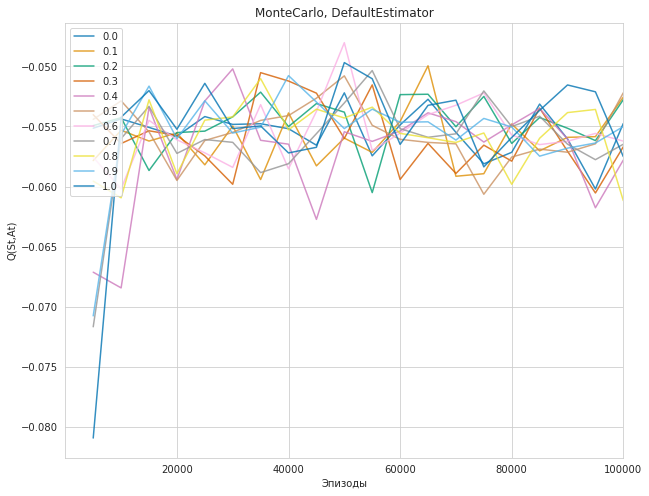

CPU times: user 28min 58s, sys: 545 ms, total: 28min 58s
Wall time: 28min 57s


In [91]:
%%time
total_episodes = 100000
n_print = 20
stateEstimator = DefaultStateEstimator()
env_bj = BlackjackEnv(gym.make('Blackjack-v0',natural=True),False)

step,rewards = train_mc_gamma(env_bj,stateEstimator,total_episodes,n_print)
plot_many_graph(step,rewards,"MonteCarlo, DefaultEstimator")

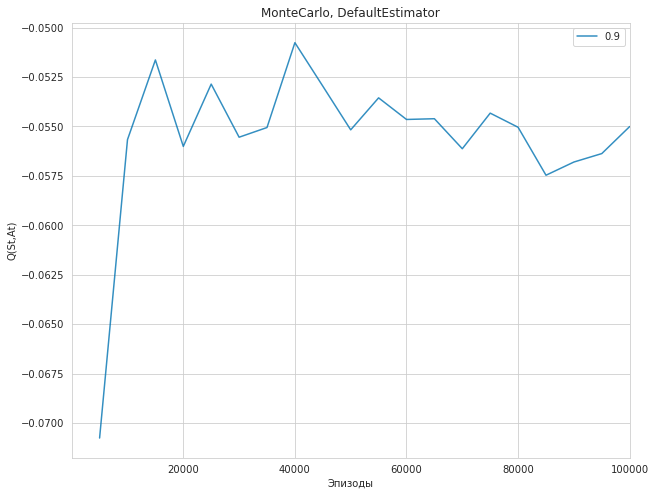

In [108]:
plot_many_graph(step,{0.9:rewards[0.9]},"MonteCarlo, DefaultEstimator")

Выделим позиции с тузами в отдельное состояние


gamma= 0.9  step= 0  step= 10000  step= 20000  step= 30000  step= 40000  step= 50000  step= 60000  step= 70000  step= 80000  step= 90000  step= 99999  

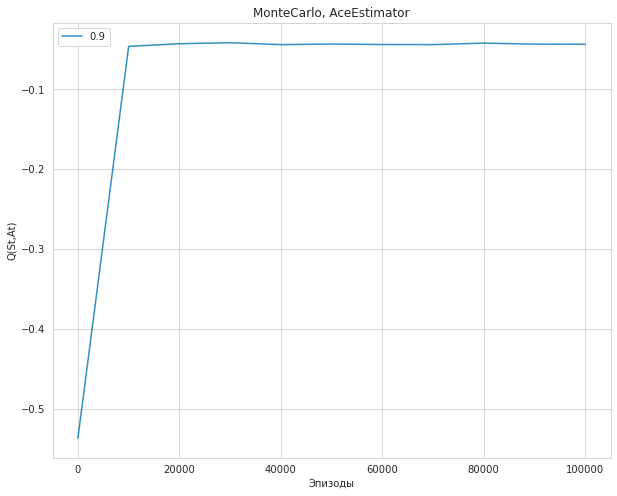

CPU times: user 6min 48s, sys: 235 ms, total: 6min 48s
Wall time: 6min 48s


In [26]:
%%time
total_episodes = 100000
n_print = 10
stateEstimator = AceStateEstimator()
env_bj = BlackjackEnv(gym.make('Blackjack-v0',natural=True),False)

# step,rewards = train_mc_gamma(env_bj,stateEstimator,total_episodes,n_print)
print_step = total_episodes//n_print
rewards = {}
gamma = 0.9
print("\ngamma=",gamma,end="  ")
algo = MonteCarloBjRl(env_bj,stateEstimator,gamma)
observer = RlObserver(env_bj,{},stateEstimator,print_step)
for i in range(total_episodes):
    Ret,pi = algo.step()
    observer.view(i,Ret,pi)          
values = observer.view(i,Ret,pi,True)
algo.close()
rewards[gamma] = observer.getValues("Reward")
step = observer.getSteps()
plot_many_graph(step,rewards,"MonteCarlo, AceEstimator",0)

In [13]:
class QLearningBjRl(object):
    """ Q-Learning """
    
    def __init__(self,env,stateEstimator,alpha=0.05,gamma=0.9,eps=0.1):
        self.env = env
        self.stateEstimator = stateEstimator        
        self.alpha = alpha
        self.gamma = gamma        
        self.eps = eps        
        self.Q = 0.0000001*np.random.random((stateEstimator.ns(), stateEstimator.na()))
        self.pi = QStrategy(self.Q, eps)
    
    def close(self):
        self.env.close()
        
    def step(self):                        
        self.env.reset(shuffle=False)                
        st = self.stateEstimator.state(self.env.player(),self.env.deck_state())  
        is_done = False
        while not is_done:
            at = self.pi.select_eps(st)
            observation, reward, is_done, info = self.env.step(at)
            stn = self.stateEstimator.state(self.env.player(),self.env.deck_state())
            q_max = 0
            if stn!=-1 and at!=0:
                q_max = np.max(self.Q[stn])
                        
            self.Q[st][at] = self.Q[st][at] + self.alpha*(reward+self.gamma*q_max-self.Q[st][at])                
            self.pi.update(st,self.Q)
            st = stn
            
        return self.Q,self.pi     

In [11]:
def train_ql(env_bj,stateEstimator,params,total_episodes=10000,n_print=5):
    """ перебираем гамма и считаем обучение MC """
    print_step = total_episodes//n_print
    rewards = {}
    for p in params.items():    
        alpha = p[1][0]
        gamma = p[1][1]
        eps = p[1][2]
        print("\n",p[0])
        algo = QLearningBjRl(env_bj,stateEstimator,alpha,gamma,eps)
        observer = RlObserver(env_bj,{},stateEstimator,print_step)

        for i in range(total_episodes):
            Ret,pi = algo.step()
            observer.view(i,Ret,pi)          
        values = observer.view(i,Ret,pi,True)
        algo.close()
        rewards[p[0]] = observer.getValues("Reward")
        step = observer.getSteps()
    return step,rewards

In [118]:
params = {"0.05_0.9_0.1":[0.05,0.9,0.1],
          "0.05_0.9_0.5":[0.05,0.9,0.5],
          "0.05_0.9_0.9":[0.05,0.9,0.9],
          "0.05_0.5_0.1":[0.05,0.5,0.1],
          "0.05_0.5_0.5":[0.05,0.5,0.5],
          "0.05_0.5_0.9":[0.05,0.5,0.9],          
          "0.05_0.1_0.1":[0.05,0.1,0.1],
          "0.05_0.1_0.5":[0.05,0.1,0.5],
          "0.05_0.1_0.9":[0.05,0.1,0.9],
          
          "0.5_0.9_0.1":[0.5,0.9,0.1],
          "0.5_0.9_0.5":[0.5,0.9,0.5],
          "0.5_0.9_0.9":[0.5,0.9,0.9],
          "0.5_0.5_0.1":[0.5,0.5,0.1],
          "0.5_0.5_0.5":[0.5,0.5,0.5],
          "0.5_0.5_0.9":[0.5,0.5,0.9],          
          "0.5_0.1_0.1":[0.5,0.1,0.1],
          "0.5_0.1_0.5":[0.5,0.1,0.5],
          "0.5_0.1_0.9":[0.5,0.1,0.9],
          
          "0.9_0.9_0.1":[0.9,0.9,0.1],
          "0.9_0.9_0.5":[0.9,0.9,0.5],
          "0.9_0.9_0.9":[0.9,0.9,0.9],
          "0.9_0.5_0.1":[0.9,0.5,0.1],
          "0.9_0.5_0.5":[0.9,0.5,0.5],
          "0.9_0.5_0.9":[0.9,0.5,0.9],          
          "0.9_0.1_0.1":[0.9,0.1,0.1],
          "0.9_0.1_0.5":[0.9,0.1,0.5],
          "0.9_0.1_0.9":[0.9,0.1,0.9]                    
         }


 0.05_0.9_0.1
step= 0  step= 200000  step= 400000  step= 600000  step= 800000  step= 999999  
 0.05_0.9_0.5
step= 0  step= 200000  step= 400000  step= 600000  step= 800000  step= 999999  
 0.05_0.9_0.9
step= 0  step= 200000  step= 400000  step= 600000  step= 800000  step= 999999  
 0.05_0.5_0.1
step= 0  step= 200000  step= 400000  step= 600000  step= 800000  step= 999999  
 0.05_0.5_0.5
step= 0  step= 200000  step= 400000  step= 600000  step= 800000  step= 999999  
 0.05_0.5_0.9
step= 0  step= 200000  step= 400000  step= 600000  step= 800000  step= 999999  
 0.05_0.1_0.1
step= 0  step= 200000  step= 400000  step= 600000  step= 800000  step= 999999  
 0.05_0.1_0.5
step= 0  step= 200000  step= 400000  step= 600000  step= 800000  step= 999999  
 0.05_0.1_0.9
step= 0  step= 200000  step= 400000  step= 600000  step= 800000  step= 999999  
 0.5_0.9_0.1
step= 0  step= 200000  step= 400000  step= 600000  step= 800000  step= 999999  
 0.5_0.9_0.5
step= 0  step= 200000  step= 400000  step= 6000

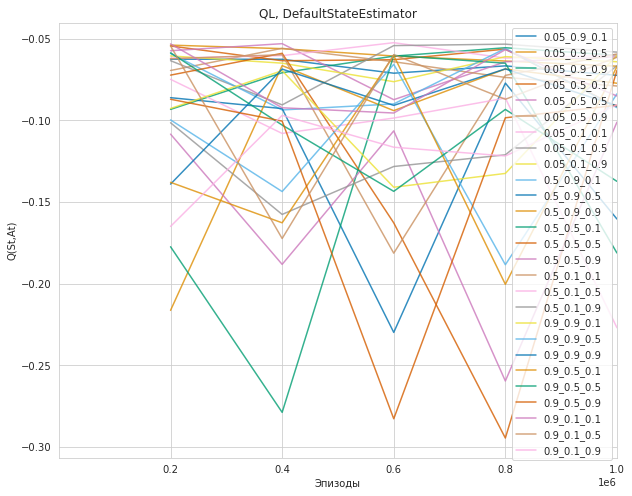

CPU times: user 42min 39s, sys: 10.8 s, total: 42min 50s
Wall time: 42min 35s


In [120]:
%%time
total_episodes = 1000000
n_print = 5
print_step = total_episodes//n_print

stateEstimator = DefaultStateEstimator()
env_bj = BlackjackEnv(gym.make('Blackjack-v0',natural=True),False)

step,rewards = train_ql(env_bj,stateEstimator,params,total_episodes,n_print)
plot_many_graph(step,rewards,"QL, DefaultStateEstimator")

Достаточно красиво выглядит '0.05_0.9_0.9'.
Скорее всего лучшие варианты alpha уменьшать, gamma=1, eps=0.9

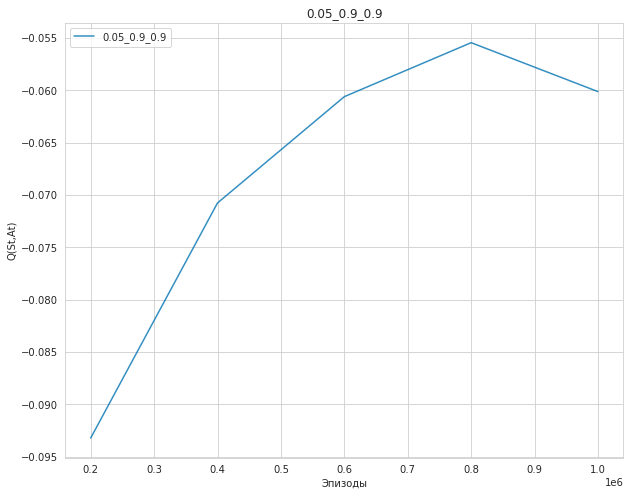

In [274]:
plot_many_graph(step,{'0.05_0.9_0.9':rewards['0.05_0.9_0.9']},'0.05_0.9_0.9')


 0.05_0.9_0.1
step= 0  step= 200000  step= 400000  step= 600000  step= 800000  step= 999999  
 0.05_0.9_0.5
step= 0  step= 200000  step= 400000  step= 600000  step= 800000  step= 999999  
 0.05_0.9_0.9
step= 0  step= 200000  step= 400000  step= 600000  step= 800000  step= 999999  
 0.05_0.5_0.1
step= 0  step= 200000  step= 400000  step= 600000  step= 800000  step= 999999  
 0.05_0.5_0.5
step= 0  step= 200000  step= 400000  step= 600000  step= 800000  step= 999999  
 0.05_0.5_0.9
step= 0  step= 200000  step= 400000  step= 600000  step= 800000  step= 999999  
 0.05_0.1_0.1
step= 0  step= 200000  step= 400000  step= 600000  step= 800000  step= 999999  
 0.05_0.1_0.5
step= 0  step= 200000  step= 400000  step= 600000  step= 800000  step= 999999  
 0.05_0.1_0.9
step= 0  step= 200000  step= 400000  step= 600000  step= 800000  step= 999999  
 0.5_0.9_0.1
step= 0  step= 200000  step= 400000  step= 600000  step= 800000  step= 999999  
 0.5_0.9_0.5
step= 0  step= 200000  step= 400000  step= 6000

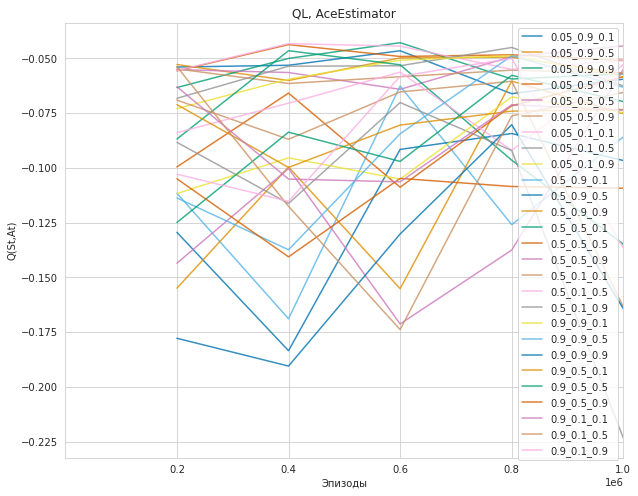

CPU times: user 42min 42s, sys: 11.5 s, total: 42min 54s
Wall time: 42min 38s


In [121]:
%%time
total_episodes = 1000000
n_print = 5
print_step = total_episodes//n_print

stateEstimator = AceStateEstimator()
env_bj = BlackjackEnv(gym.make('Blackjack-v0',natural=True),False)

step2,rewards2 = train_ql(env_bj,stateEstimator,params,total_episodes,n_print)
plot_many_graph(step2,rewards2,"QL, AceEstimator")

step= 0  step= 100000  step= 200000  step= 300000  step= 400000  step= 500000  step= 600000  step= 700000  step= 800000  step= 900000  step= 999999  
pi= [eps=0.9, pi=[1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0]]
Rewards= [-0.222909, -0.042701, -0.044432, -0.0429925, -0.044199, -0.044046, -0.041298, -0.0418475, -0.043025, -0.0434465, -0.04396]


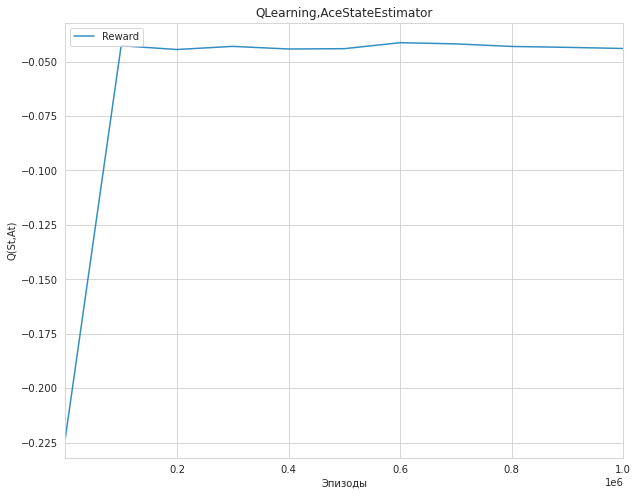

CPU times: user 5min 4s, sys: 128 ms, total: 5min 5s
Wall time: 5min 4s


In [29]:
%%time
total_episodes = 1000000
print_step = total_episodes//10
stateEstimator = AceStateEstimator() 
env_bj_ex = BlackjackEnv(BlackjackEnvCardCount(natural=True),False)
algo = QLearningBjRl(env_bj_ex,stateEstimator,0.00001,1.0,eps=0.9)
observer = RlObserver(env_bj_ex,{},stateEstimator,print_step)

for i in range(total_episodes):
    Ret,pi = algo.step()    
    observer.view(i,Ret,pi)      
    
values = observer.view(i,Ret,pi,True)

algo.close()
print("\npi=",pi)
print("Rewards=",observer.getValues("Reward"))
plot_observer(observer,"QLearning,AceStateEstimator",0)

## Часть вторая, удвоенная

In [12]:
from gym import spaces
from gym.utils import seeding

class Deck(object):
    """ Колода карт. 
    Умеет считать свое состояние.
    Есть небольшое отклонение от "правды" - 
    карту диллера для состояния считаем когда ее раздали - для упрощения подсчёта. 
    Чтобы не делать отложенный расчёт.
    """
    def __init__(self):
#         self.card_score = {2:0.5,3:1,4:1,5:1.5,6:1,7:0.5,8:0,9:-0.5,10:-1,1:-1}
        self.card_score = {2:1,3:2,4:2,5:3,6:2,7:1,8:0,9:-1,10:-2,1:-2}
        self.start_deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
                           1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
                           1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10,
                           1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
        self.deck = self.start_deck.copy()
        self.score = 0
        self.mn = -20
        self.mx = 20
        
    def draw_card(self,np_random=np.random):
        if len(self.deck)<10:
            self.reset()
        idx = np_random.randint(len(self.deck))        
        card = self.deck.pop(idx)
        self.score +=self.card_score[card]        
        return card

    def draw_hand(self,np_random=np.random):
        return [self.draw_card(np_random), self.draw_card(np_random)]
    
    def reset(self,shuffle = False,need_reset=False):
        if need_reset or len(self.deck)<15:
            self.score = 0
            if shuffle:
                self.deck = self.start_deck.copy()
                sz = np.random.randint(52-15)
                for i in range(sz):
                    self.draw_card()
            else:
                self.deck = self.start_deck.copy()
            
    
    def n_state(self):
        return 1+self.mx-self.mn
    
    def getState(self):
        sc = int(self.score)
        if sc<self.mn:
            sc=self.mn
        if sc>self.mx:
            sc=self.mx
        return sc-self.mn;
            

class BlackjackEnvCardCount(gym.Env):
    """ Окружение для Blackjack с командой double и возможностью подсчёта карт """
    def __init__(self, natural=False):
        self.deck = Deck()        
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()        
        self.natural = natural        
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action==2:  # double: 
            self.player.append(self.deck.draw_card(self.np_random))
            if blackjack.is_bust(self.player):
                done = True
                reward = -2.            
            else:
                done = True
                while blackjack.sum_hand(self.dealer) < 17:
                    self.dealer.append(self.deck.draw_card(self.np_random))
                reward = 2*blackjack.cmp(blackjack.score(self.player), blackjack.score(self.dealer))                                
        elif action==1:  # hit: add a card to players hand and return
            self.player.append(self.deck.draw_card(self.np_random))
            if blackjack.is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while blackjack.sum_hand(self.dealer) < 17:
                self.dealer.append(self.deck.draw_card(self.np_random))
            reward = blackjack.cmp(blackjack.score(self.player), blackjack.score(self.dealer))
            if self.natural and blackjack.is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (blackjack.sum_hand(self.player), self.dealer[0], blackjack.usable_ace(self.player))

    def reset(self,shuffle=False):
        self.deck.reset(shuffle)        
        self.dealer = self.deck.draw_hand(self.np_random)
        self.player = self.deck.draw_hand(self.np_random)
        return self._get_obs()

step= 0  step= 10000  step= 20000  step= 30000  step= 40000  step= 50000  step= 60000  step= 70000  step= 80000  step= 90000  step= 99999  
pi= [eps=0, pi=[1 1 1 1 1 1 2 2 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0]]
Rewards= [-0.882593, -0.0579525, -0.035166, -0.037886, -0.0338895, -0.035448, -0.03492, -0.034919, -0.0312875, -0.0335355, -0.03154]


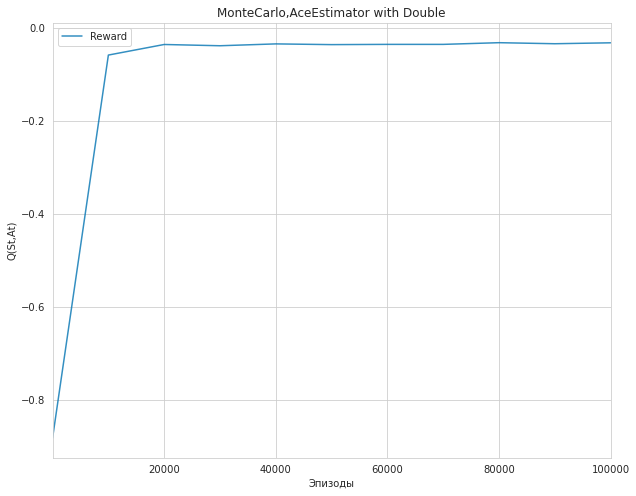

CPU times: user 4min 13s, sys: 47.5 ms, total: 4min 13s
Wall time: 4min 13s


In [28]:
%%time
total_episodes = 100000
print_step = total_episodes//10
stateEstimator = AceStateEstimator(3) # это с double
env_bj_ex = BlackjackEnv(BlackjackEnvCardCount(natural=True),False)
algo = MonteCarloBjRl(env_bj_ex,stateEstimator,gamma=0.9)
observer = RlObserver(env_bj_ex,{},stateEstimator,print_step)

for i in range(total_episodes):
    Ret,pi = algo.step()
    observer.view(i,Ret,pi)      
    
values = observer.view(i,Ret,pi,True)

algo.close()
print("\npi=",pi)
print("Rewards=",observer.getValues("Reward"))
plot_observer(observer,"MonteCarlo,AceEstimator with Double",0)

step= 0  step= 100000  step= 200000  step= 300000  step= 400000  step= 500000  step= 600000  step= 700000  step= 800000  step= 900000  step= 999999  
pi= [eps=0.9, pi=[1 1 1 1 1 1 2 2 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0]]
Rewards= [-0.632227, -0.0366565, -0.0304315, -0.03113, -0.033139, -0.03769, -0.0296065, -0.031246, -0.032534, -0.033451, -0.0311775]


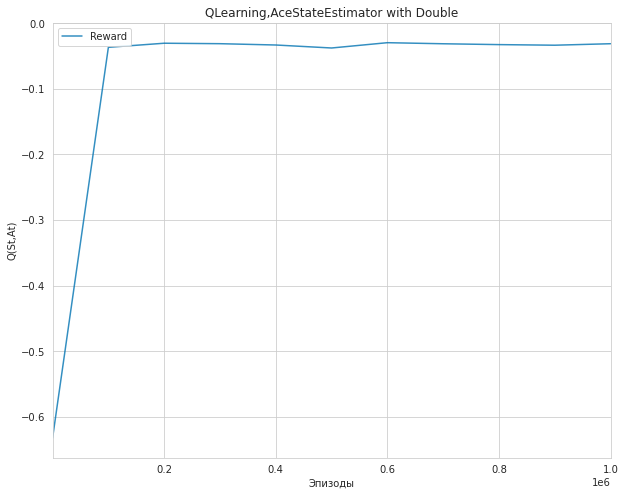

CPU times: user 4min 58s, sys: 107 ms, total: 4min 58s
Wall time: 4min 58s


In [27]:
%%time
total_episodes = 1000000
print_step = total_episodes//10
stateEstimator = AceStateEstimator(3) # это с double
env_bj_ex = BlackjackEnv(BlackjackEnvCardCount(natural=True),False)
algo = QLearningBjRl(env_bj_ex,stateEstimator,0.00001,1.0,eps=0.9)
observer = RlObserver(env_bj_ex,{},stateEstimator,print_step)

for i in range(total_episodes):
    Ret,pi = algo.step()    
    observer.view(i,Ret,pi)      
    
values = observer.view(i,Ret,pi,True)

algo.close()
print("\npi=",pi)
print("Rewards=",observer.getValues("Reward"))
plot_observer(observer,"QLearning,AceStateEstimator with Double",0)

## Часть третья, в главной роли — Дастин Хоффман

step= 0  step= 400000  step= 800000  step= 1200000  step= 1600000  step= 2000000  step= 2400000  step= 2800000  step= 3200000  step= 3600000  step= 3999999  
pi= [eps=0, pi=[0 1 1 ... 1 2 2]]
Rewards= [-0.5148525, -0.0203415, -0.015494, -0.012231, -0.0113485, -0.009938, -0.00921, -0.0067555, -0.006715, -0.009304, -0.0076885]


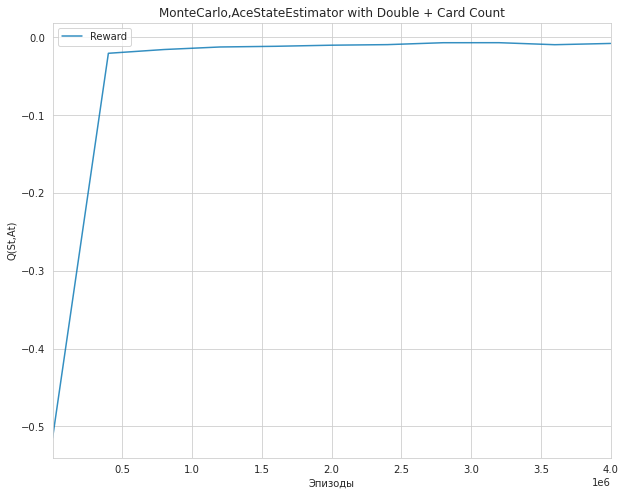

CPU times: user 6min 50s, sys: 1.17 s, total: 6min 51s
Wall time: 6min 50s


In [18]:
%%time
total_episodes = 4000000
print_step = total_episodes//10
env_bj_cc = BlackjackEnv(BlackjackEnvCardCount(natural=True),True) # включили подсчёт карт
stateEstimator = AceStateEstimator(3,n_deck=env_bj_cc.n_deck_state()) 

algo = MonteCarloBjRl(env_bj_cc,stateEstimator,gamma=0.9)
observer = RlObserver(env_bj_cc,{},stateEstimator,print_step)

for i in range(total_episodes):
    Ret,pi = algo.step()    
    observer.view(i,Ret,pi)      
    
values = observer.view(i,Ret,pi,True)

algo.close()
print("\npi=",pi)
print("Rewards=",observer.getValues("Reward"))
plot_observer(observer,"MonteCarlo,AceStateEstimator with Double + Card Count",0)

step= 0  step= 1000000  step= 2000000  step= 3000000  step= 4000000  step= 5000000  step= 6000000  step= 7000000  step= 8000000  step= 9000000  step= 9999999  
pi= [eps=0.9, pi=[1 1 1 ... 2 0 0]]
Rewards= [-0.5716175, -0.0163405, -0.0136325, -0.011602, -0.009401, -0.0122165, -0.0095575, -0.014148, -0.012035, -0.0119745, -0.008912]


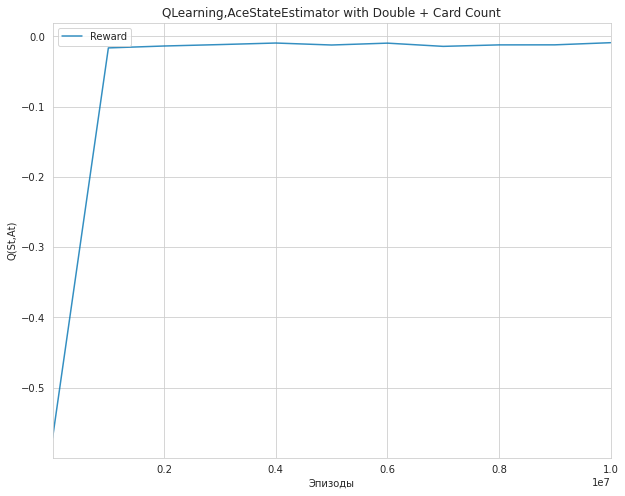

CPU times: user 10min 49s, sys: 2.57 s, total: 10min 52s
Wall time: 10min 48s


In [19]:
%%time
total_episodes = 10000000
print_step = total_episodes//10
env_bj_cc = BlackjackEnv(BlackjackEnvCardCount(natural=True),True)  # включили подсчёт карт
stateEstimator = AceStateEstimator(3,n_deck=env_bj_cc.n_deck_state()) 

algo = QLearningBjRl(env_bj_cc,stateEstimator,alpha=0.00005,gamma=1.0,eps=0.9) # QLearning
observer = RlObserver(env_bj_cc,{},stateEstimator,print_step)

for i in range(total_episodes):
    Ret,pi = algo.step()    
    observer.view(i,Ret,pi)      
    
values = observer.view(i,Ret,pi,True)

algo.close()
print("\npi=",pi)
print("Rewards=",observer.getValues("Reward"))
plot_observer(observer,"QLearning,AceStateEstimator with Double + Card Count",0)

## Часть четвёртая, опциональная

Моделировать split красиво - есть сложности. Поэтому захардкодим Окружение, Стратегию, Оценщика и МонтеКарло - специально заточенные под split.  
При split - карты игрока бьются на 2 руки. Сначала отыгрывается одна рука до конца. Потом 1-я рука заменяется на вторую и повторно отыгрывается.  
Но при подсчёте карт они учитываются сразу - это не должно оказать серьезного влияния.

In [21]:
class BlackjackEnvSplit(gym.Env):
    """ Окружение для Blackjack с командой double и возможностью подсчёта карт + SPLIT """
    def __init__(self, natural=False):
        self.deck = Deck()        
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()        
        self.natural = natural        
        self.can_split = False
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)        
        self.can_split = False
        if action==3:  # split: 
            self.player_split = [self.player[0]]
            self.player.pop(1)            
            self.player.append(self.deck.draw_card(self.np_random))
            self.player_split.append(self.deck.draw_card(self.np_random))            
            done = False
            reward = 0                            
        elif action==2:  # double: 
            self.player.append(self.deck.draw_card(self.np_random))
            if blackjack.is_bust(self.player):
                done = True
                reward = -2.            
            else:
                done = True
                while blackjack.sum_hand(self.dealer) < 17:
                    self.dealer.append(self.deck.draw_card(self.np_random))
                reward = 2*blackjack.cmp(blackjack.score(self.player), blackjack.score(self.dealer))                                
        elif action==1:  # hit: add a card to players hand and return
            self.player.append(self.deck.draw_card(self.np_random))
            if blackjack.is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick: play out the dealers hand, and score
            done = True
            while blackjack.sum_hand(self.dealer) < 17:
                self.dealer.append(self.deck.draw_card(self.np_random))
            reward = blackjack.cmp(blackjack.score(self.player), blackjack.score(self.dealer))
            if self.natural and blackjack.is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def split_change(self):
        self.dealer = self.deck.draw_hand(self.np_random)
        self.player = self.player_split
        self.player.append(self.deck.draw_card(self.np_random))
    
    def _get_obs(self):
        return (blackjack.sum_hand(self.player), self.dealer[0], blackjack.usable_ace(self.player))

    def reset(self,shuffle=False):        
        self.deck.reset(shuffle)        
        self.dealer = self.deck.draw_hand(self.np_random)
        self.player = self.deck.draw_hand(self.np_random)        
        self.can_split = (self.player[0]==self.player[1])
        return self._get_obs()

In [22]:
class SplitStrategy(object):
    """ Стратегия, которая задаётся функцией Q. 
    Может становиться e-greedy.
    По-умолчанию eps==0.
    """
    def __init__(self,Q,eps=0):           
        self.pi = np.argmax(Q,axis=1)
        self.eps = eps
        self.na = Q.shape[1]

    def __str__(self):
        return "[eps="+str(self.eps)+", pi="+str(self.pi)+"]"
        
    def select(self,st):
        return self.pi[st]    
    
    def update(self,st,Q):
        self.pi[st] = np.argmax(Q[st])
        
class SplitStateEstimator(object):    
    """ Усложненный оценщик состояний при игре в карты. 
    Имеет 38 базовых состояний руки в зависимости суммы карт на руке.
    Различает состояния когда на руках есть туз. И возможность сплитов.
    при переборе состояние = -1
    Базовые состояния:
    Первые 0..9 : возможен split на 1..10
    10-28: сумма карт и нет туза
    29-37: сумма карт с usable_ace
    + они сдвигаются на 38*состояние колоды
    """
 
    def __init__(self,env,na=2,n_deck=1):
        self.env = env
        self._na = na        
        self.n_deck = n_deck   
        self.can_split = False
            
    def state(self,hand,deck_state=0):                
        self.can_split = False
        if blackjack.is_bust(hand):
            return -1
        if self.env.can_split and hand[0]==hand[1]: # возможен split
            self.can_split = True
            return hand[0]-1+deck_state*self.ns_per_deck()
        if blackjack.usable_ace(hand):
            return blackjack.sum_hand(hand)+18-12+10+ deck_state*self.ns_per_deck()
        else:
            return blackjack.sum_hand(hand)-4+10+ deck_state*self.ns_per_deck()
    
    def ns_per_deck(self):
        return 38
    
    def ns(self):
        return self.ns_per_deck()*self.n_deck
    
    def na(self):
        if self.can_split:
            return 4
        return 3
    
    def initQ(self):
        Q = np.random.random((self.ns(),4))
        for d in range(0,self.n_deck):
            for j in range(10,self.ns_per_deck()):
                idx = j+d*self.ns_per_deck()
                Q[idx][3] = -1e+12
        return Q
    
class MonteCarloBjRl_Split(object):    
    """ Реализация метода "Monte Carlo control with exploring starts" + Split
    Создается на основе: 
        окружения BlackjackEnv
        оценщика DefaultStateEstimator, AceStateEstimator
        gamma
    """
    def __init__(self, env, stateEstimator, gamma=0.9):        
        self.env = env
        self.gamma = gamma
        self.stateEstimator = stateEstimator
        self.Q = stateEstimator.initQ()
        self.pi = SplitStrategy(self.Q)
        self.Ret = [[ Stat() for _ in range(4)] for _ in range(stateEstimator.ns())]
    
    def close(self):
        self.env.close()
        
    def step(self):                
        env = self.env
        env.reset(shuffle=False)
        s,a,r=[],[],[]            
        s0 = self.stateEstimator.state(env.player(),env.deck_state())        
        s.append(s0)
        
        a0 = np.random.randint(stateEstimator.na())            
        a.append(a0)
        observation, reward, is_done, info = env.step(a0)
        r.append(reward)
                
        while not is_done:
            st = self.stateEstimator.state(env.player(),env.deck_state())
            s.append(st)
            at = self.pi.select(st)
            a.append(at) 
            observation, reward, is_done, info = env.step(at)
            r.append(reward)
        g=0
        T = len(r)
        for t in range(T-1,-1,-1):
            g = self.gamma*g+r[t]        
            st = s[t]               
            self.Ret[st][a[t]].append(g)            
            self.Q[st][a[t]] = self.Ret[st][a[t]].mean()
            self.pi.update(st,self.Q)
            
        if a0==3:
            env.split_change()
            s,a,r=[s0],[a0],[0]
            is_done = False
            while not is_done:
                st = self.stateEstimator.state(env.player(),env.deck_state())
                s.append(st)
                at = self.pi.select(st)
                a.append(at) 
                observation, reward, is_done, info = env.step(at)
                r.append(reward)
            g=0
            T = len(r)
            for t in range(T-1,-1,-1):
                g = self.gamma*g+r[t]        
                st = s[t]                       
                self.Ret[st][a[t]].append(g)
                
                self.Q[st][a[t]] = self.Ret[st][a[t]].mean()
                self.pi.update(st,self.Q)
            
        return self.Ret,self.pi    

In [23]:
%%time
total_episodes = 10000000
print_step = total_episodes//10

env_bj_ex = BlackjackEnv(BlackjackEnvSplit(natural=True),True) # с подсчётом карт и split
stateEstimator = SplitStateEstimator(env_bj_ex,4,n_deck=env_bj_ex.n_deck_state()) 
algo = MonteCarloBjRl_Split(env_bj_ex,stateEstimator,gamma=0.9)
observer = RlObserver(env_bj_ex,{},stateEstimator,print_step)

for i in range(total_episodes):
    Ret,pi = algo.step()    
    observer.view(i,Ret,pi)
    if i%print_step==0:
        print("R=",observer.getValues("Reward")[-1],end='  ')
    
    
values = observer.view(i,Ret,pi,True)

algo.close()
print("\npi=",pi)
print("Rewards=",observer.getValues("Reward"))

step= 0  R= -0.614911  step= 1000000  R= -0.0154335  step= 2000000  R= -0.0093625  step= 3000000  R= -0.009217  step= 4000000  R= -0.008238  step= 5000000  R= -0.0103395  step= 6000000  R= -0.0082095  step= 7000000  R= -0.0090165  step= 8000000  R= -0.0090995  step= 9000000  R= -0.00886  step= 9999999  
pi= [eps=0, pi=[3 1 1 ... 2 0 0]]
Rewards= [-0.614911, -0.0154335, -0.0093625, -0.009217, -0.008238, -0.0103395, -0.0082095, -0.0090165, -0.0090995, -0.00886, -0.008449]
CPU times: user 11min, sys: 4.03 s, total: 11min 4s
Wall time: 10min 58s


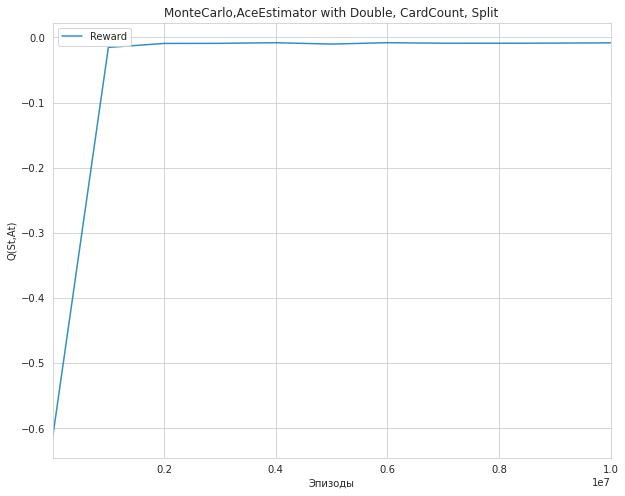

In [24]:
plot_observer(observer,"MonteCarlo,AceEstimator with Double, CardCount, Split",0)